## Trim `hrdata.parquet.snappy` for a training sample

In [1]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

#### Let's determine the sizes of traing/testing samples

In [2]:
print 31**3

29791


In [3]:
print 31**2*3

2883


In [4]:
print 30**3

27000


In [5]:
numsect = 31**3

> 20000 training sample and 9000 testing sample 

#### Read `hrdata.parquet.snappy` to a pandas/dataframe, and trim it!

In [6]:
import pyarrow.parquet as pq

In [7]:
%time
hrdf = pq.read_table('hrdata.parquet.snappy').to_pandas()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


In [8]:
hrdf.head()

,haloid,px,py,pz,halomass,isect
0,2164471,113.276787,136.558777,158.994751,7.075400e+14,0
1,341850,148.616104,193.995865,172.711838,6.187440e+14,0
2,2654219,156.185623,115.296417,168.603867,5.634040e+14,0
3,1339587,188.427338,189.256927,168.730972,3.790270e+14,0
4,24784,145.331253,188.979660,175.401337,3.555020e+14,0


In [9]:
sys.getsizeof(hrdf)

1944000032

In [10]:
hrdf[hrdf.isect == 2000][:10]

,haloid,px,py,pz,halomass,isect
4000000,134359,335.164948,742.002258,2128.719238,4.283600e+14,2000
4000001,2245720,320.469086,754.580933,2131.292969,3.453720e+14,2000
4000002,480008,342.707184,787.741760,2101.839600,1.780080e+14,2000
4000003,134762,326.419830,713.458313,2188.218262,1.191590e+14,2000
4000004,3193581,315.241241,712.992493,2151.678467,1.149920e+14,2000
4000005,6551121,323.842133,745.397156,2142.352051,1.144140e+14,2000
4000006,6330114,300.389343,705.541321,2109.851807,1.141620e+14,2000
4000007,440544,388.964355,749.215515,2196.093262,1.122040e+14,2000
4000008,8168306,389.101257,703.775879,2165.708740,1.102020e+14,2000
4000009,249409,357.410156,746.634705,2174.904541,1.027600e+14,2000


In [11]:
tmp = hrdf[hrdf.isect == 2000][:5]

In [12]:
tmp[['px','py','pz']]

,px,py,pz
4000000,335.164948,742.002258,2128.719238
4000001,320.469086,754.580933,2131.292969
4000002,342.707184,787.741760,2101.839600
4000003,326.419830,713.458313,2188.218262
4000004,315.241241,712.992493,2151.678467


In [13]:
tmp[['px','py','pz']].stack()

4000000  px     335.164948
         py     742.002258
         pz    2128.719238
4000001  px     320.469086
         py     754.580933
         pz    2131.292969
4000002  px     342.707184
         py     787.741760
         pz    2101.839600
4000003  px     326.419830
         py     713.458313
         pz    2188.218262
4000004  px     315.241241
         py     712.992493
         pz    2151.678467
dtype: float32

In [14]:
tmp[['px','py','pz']].stack().values

array([ 335.16495,  742.00226, 2128.7192 ,  320.4691 ,  754.58093,
       2131.293  ,  342.70718,  787.74176, 2101.8396 ,  326.41983,
        713.4583 , 2188.2183 ,  315.24124,  712.9925 , 2151.6785 ],
      dtype=float32)

## Extract top 400 halos in mass

### 20000 training set

In [15]:
numhalo = 400 # 400 points for each box 

In [16]:
hrtrain =[]

for isample in range(0,20000):
#for isample in range(0,5):
    tmpdf = hrdf[hrdf.isect == isample][:numhalo]
    ## normalize the coordinates in 1x1x1 cube 
    tmpdf = tmpdf.abs() # make some negative coordinate glitches positive forcefully. 
    tmpdf.px = 0.01*(tmpdf.px - np.floor(tmpdf.px.min())) #normalize 100Mpc to 1, unity
    tmpdf.py = 0.01*(tmpdf.py - np.floor(tmpdf.py.min()))
    tmpdf.pz = 0.01*(tmpdf.pz - np.floor(tmpdf.pz.min()))
    
    tmpdf['srank'] = tmpdf\
    .apply(lambda row: np.sqrt((row['px']-0.5)**2 +(row['px']-0.5)**2 +(row['px']-0.5)**2), axis=1)
    tmpdf = tmpdf.sort_values(by='srank').reset_index(drop=True)
    tmp = tmpdf[['px','py','pz']].stack()
    hrtrain.append(tmp.values)
    if isample % 1000 == 0:
        print 'Working ... ',isample,'/20000' 

hrtrain = np.float32(hrtrain)

Working ...  0 /20000
Working ...  1000 /20000
Working ...  2000 /20000
Working ...  3000 /20000
Working ...  4000 /20000
Working ...  5000 /20000
Working ...  6000 /20000
Working ...  7000 /20000
Working ...  8000 /20000
Working ...  9000 /20000
Working ...  10000 /20000
Working ...  11000 /20000
Working ...  12000 /20000
Working ...  13000 /20000
Working ...  14000 /20000
Working ...  15000 /20000
Working ...  16000 /20000
Working ...  17000 /20000
Working ...  18000 /20000
Working ...  19000 /20000


In [17]:
hrtrain.dtype

dtype('float32')

In [20]:
hrtrain.shape

(20000, 1200)

### 7000 test set

In [21]:
hrtest =[]

for isample in range(20000,27000):
#for isample in range(20000,20005):
    tmpdf = hrdf[hrdf.isect == isample][:numhalo]
    ## normalize the coordinates in 1x1x1 cube 
    tmpdf = tmpdf.abs() # some coordinate glitches : which have negative values. 
    tmpdf.px = 0.01*(tmpdf.px - np.floor(tmpdf.px.min()))
    tmpdf.py = 0.01*(tmpdf.py - np.floor(tmpdf.py.min()))
    tmpdf.pz = 0.01*(tmpdf.pz - np.floor(tmpdf.pz.min()))
    
    tmpdf['srank'] = tmpdf\
    .apply(lambda row: np.sqrt((row['px']-0.5)**2 +(row['px']-0.5)**2 +(row['px']-0.5)**2), axis=1)
    tmpdf = tmpdf.sort_values(by='srank').reset_index(drop=True)
    tmp = tmpdf[['px','py','pz']].stack()
    hrtest.append(tmp.values)

hrtest = np.float32(hrtest)

In [22]:
hrtest.shape

(7000, 1200)

## Generate Random Sets 

> 20000 train 7000 test samples

In [23]:
nTrainSamples = 20000
nTestSamples = 7000

In [24]:
def genRandomCube(nsize):
    re = []
    for i in range(nsize): 
        tmpPoint = np.random.random(3)
        re.append(tmpPoint)
    return np.float32(re)

In [25]:
rdtrain = []
isample = 0

while isample < nTrainSamples:
    tmpdf = pd.DataFrame(genRandomCube(numhalo),columns=['px','py','pz'])
    
    tmpdf['srank'] = tmpdf\
    .apply(lambda row: np.sqrt((row['px']-0.5)**2 +(row['px']-0.5)**2 +(row['px']-0.5)**2), axis=1)
    tmpdf = tmpdf.sort_values(by='srank').reset_index(drop=True)
    tmp = tmpdf[['px','py','pz']].stack()
    rdtrain.append(tmp.values)
    isample = isample+1

rdtrain = np.float32(rdtrain)

In [26]:
rdtrain.shape

(20000, 1200)

In [27]:
rdtest = []
isample = 0

while isample < nTestSamples:
    tmpdf = pd.DataFrame(genRandomCube(numhalo),columns=['px','py','pz'])
    tmpdf['srank'] = tmpdf\
    .apply(lambda row: np.sqrt((row['px']-0.5)**2 +(row['px']-0.5)**2 +(row['px']-0.5)**2), axis=1)
    tmpdf = tmpdf.sort_values(by='srank').reset_index(drop=True)
    tmp = tmpdf[['px','py','pz']].stack()
    rdtest.append(tmp.values)
    isample = isample+1

rdtest = np.float32(rdtest)

In [28]:
rdtest.shape

(7000, 1200)

> Plot samples 

In [29]:
rdtrain[0,:9]

array([0.49855694, 0.821905  , 0.06488563, 0.49749225, 0.17175856,
       0.49279207, 0.50519747, 0.92783904, 0.6619252 ], dtype=float32)

In [30]:
ix = np.arange(numhalo)*3
iy = np.arange(numhalo)*3 + 1
iz = np.arange(numhalo)*3 + 2

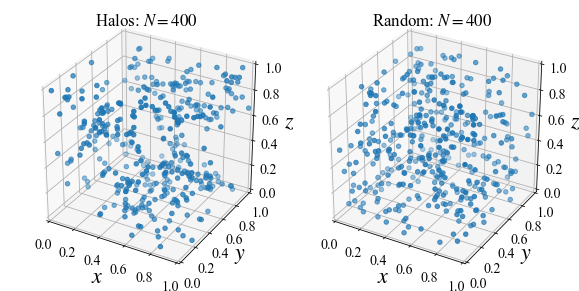

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')
ax.set_title(r'Halos: $N = 400$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.scatter(hrtrain[0,ix],hrtrain[0,iy],hrtrain[0,iz])
ax.set_xlabel(r'$x$',fontsize=22)
ax.set_ylabel(r'$y$',fontsize=22)
ax.set_zlabel(r'$z$',fontsize=22)

ax = fig.add_subplot(122, projection='3d')
ax.set_title(r'Random: $N = 400$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.scatter(rdtrain[1,ix],rdtrain[1,iy],rdtrain[1,iz])
ax.set_xlabel(r'$x$',fontsize=22)
ax.set_ylabel(r'$y$',fontsize=22)
ax.set_zlabel(r'$z$',fontsize=22)




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('sample400.png')

plt.show()

## Concatenate the two kinds of samples to a single train/test set

### Train Set

In [32]:
X_train = np.concatenate((hrtrain,rdtrain),axis=0)

In [33]:
X_train.shape

(40000, 1200)

> Classification Code : HR = 0, Random = 1

In [34]:
y_train = np.concatenate((np.full(nTrainSamples,0),np.full(nTrainSamples,1)),axis=0)

In [35]:
y_train.shape

(40000,)

> Randomize the train set 

In [36]:
lentrain = len(y_train)
irand = np.arange(lentrain)
np.random.seed(7)
np.random.shuffle(irand)

In [37]:
X_trainRand = []
y_trainRand = []

for ir in irand:
    X_trainRand.append(X_train[ir])
    y_trainRand.append(y_train[ir])

X_trainRand = np.float32(X_trainRand)
y_trainRand = np.int32(y_trainRand)

In [38]:
X_trainRand.shape

(40000, 1200)

In [39]:
y_trainRand.shape

(40000,)

In [40]:
import pickle

with open('trainRand400.pickle','wb') as f:
    pickle.dump([X_trainRand, y_trainRand],f)
f.close() #keep dumping the current results to overwrite the pickle. 

### Test Set

In [41]:
X_test = np.concatenate((hrtest,rdtest),axis=0)

In [42]:
X_test.shape

(14000, 1200)

In [43]:
y_test = np.concatenate((np.full(nTestSamples,0),np.full(nTestSamples,1)),axis=0)

In [44]:
y_test.shape

(14000,)

In [45]:
lentest = len(y_test)
irand = np.arange(lentest)
np.random.seed(9)
np.random.shuffle(irand)

In [46]:
X_testRand = []
y_testRand = []

for ir in irand:
    X_testRand.append(X_test[ir])
    y_testRand.append(y_test[ir])

X_testRand = np.float32(X_testRand)
y_testRand = np.int32(y_testRand)

In [47]:
X_testRand.shape

(14000, 1200)

In [48]:
y_testRand.shape

(14000,)

In [49]:
with open('testRand400.pickle','wb') as f:
    pickle.dump([X_testRand, y_testRand],f)
f.close() #keep dumping the current results to overwrite the pickle. 

In [50]:
pwd

u'/Users/shong/work/deeplearning/cosmo-pattern'